In [13]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_4DLorenz.recursive_LSTM_PostMeanScore_4DLorenz_T256_H05_tl_110data import \
    get_config
from configs.RecursiveVPSDE.LSTM_4DLorenz.recursive_LSTM_PostMeanScore_4DLorenz_T256_H05_tl_110data_StbleTgt import \
    get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
config = get_config()
deltaT = config.deltaT
print(config.loss_factor)

2


In [28]:
def get_drift_files(config, ts_type_str):
    ts_type = f"{ts_type_str}"
    if "_ST_" in config.scoreNet_trained_path:
        include = f"_ST_{config.ndims}DLorenz_OOSDriftTrack_"
    else:
        include = f"{config.ndims}DLorenz_OOSDriftTrack_"
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_dir):
        if "LSTM" in file and ts_type in file and include in file:
            if "OOSDriftTrack" in file and "true" in file:
                driftoostrack_true_files.append(root_dir+file)
            elif "OOSDriftTrack" in file and "local" in file:
                driftoostrack_local_files.append(root_dir+file)
    assert len(driftoostrack_true_files)>0, "No oos drift track files found"
    assert len(driftoostrack_local_files)>0, "No oos drift track files found"
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    return driftoostrack_true_files, driftoostrack_local_files, Nepochs_track

In [29]:
ts_type_str = f"{round(config.forcing_const, 3)}FConst".replace(".", "")
driftoostrack_true_files, driftoostrack_local_files, Nepochs_track = get_drift_files(config=config, ts_type_str=ts_type_str)

In [30]:
drift_track_rmses = {}
for f in zip(*[Nepochs_track, driftoostrack_true_files, driftoostrack_local_files]):
    Nepoch = f[0]
    true = f[1]
    local = f[2]
    try:
        all_true_states = np.load(true, allow_pickle=True)/np.sqrt(config.deltaT)
        all_local_states= np.load(local,allow_pickle=True)/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
    except pickle.UnpicklingError as e:
        continue
    except FileNotFoundError as e:
        print(e)
        continue
Nepochs_track = np.array(list(drift_track_rmses.keys())).flatten()
drift_track_rmses

{2: 0.05367013114706219,
 4: 0.06599971651046821,
 6: 0.05351562963136702,
 8: 0.05050476505312853,
 10: 0.051224473493518205,
 12: 0.0509074215289277,
 14: 0.05122137310356978,
 16: 0.05388682940783497,
 18: 0.0549247833027572,
 20: 0.04824491485395762,
 22: 0.04803424684703279,
 24: 0.0514952323917654,
 26: 0.04926839696329734,
 28: 0.0436504482333446,
 30: 0.042878294804865276,
 32: 0.04533377679930557,
 34: 0.04359525410058577,
 36: 0.047358562333963086,
 38: 0.04283228257632851,
 40: 0.04424861674086367,
 42: 0.04124693342485728,
 44: 0.04110046240648466,
 46: 0.042324223928001725,
 48: 0.04161794461991077,
 50: 0.04143015645636441,
 52: 0.041579744046072474,
 54: 0.04161118686859365,
 56: 0.04152235631218381,
 58: 0.04087182242001003,
 62: 0.04137803578451253,
 64: 0.04157764688975567,
 66: 0.04085763496458839,
 68: 0.04215749630823903,
 70: 0.04184994704798352,
 72: 0.042115823791621994,
 74: 0.04224337983924916,
 76: 0.040924638383150504,
 78: 0.040886870252252225,
 80: 0.04160

In [31]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.sqrt(np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])

In [ ]:
common_epochs = np.intersect1d(Nepochs_losses, Nepochs_track)
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
track_idx = [np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs]
track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]

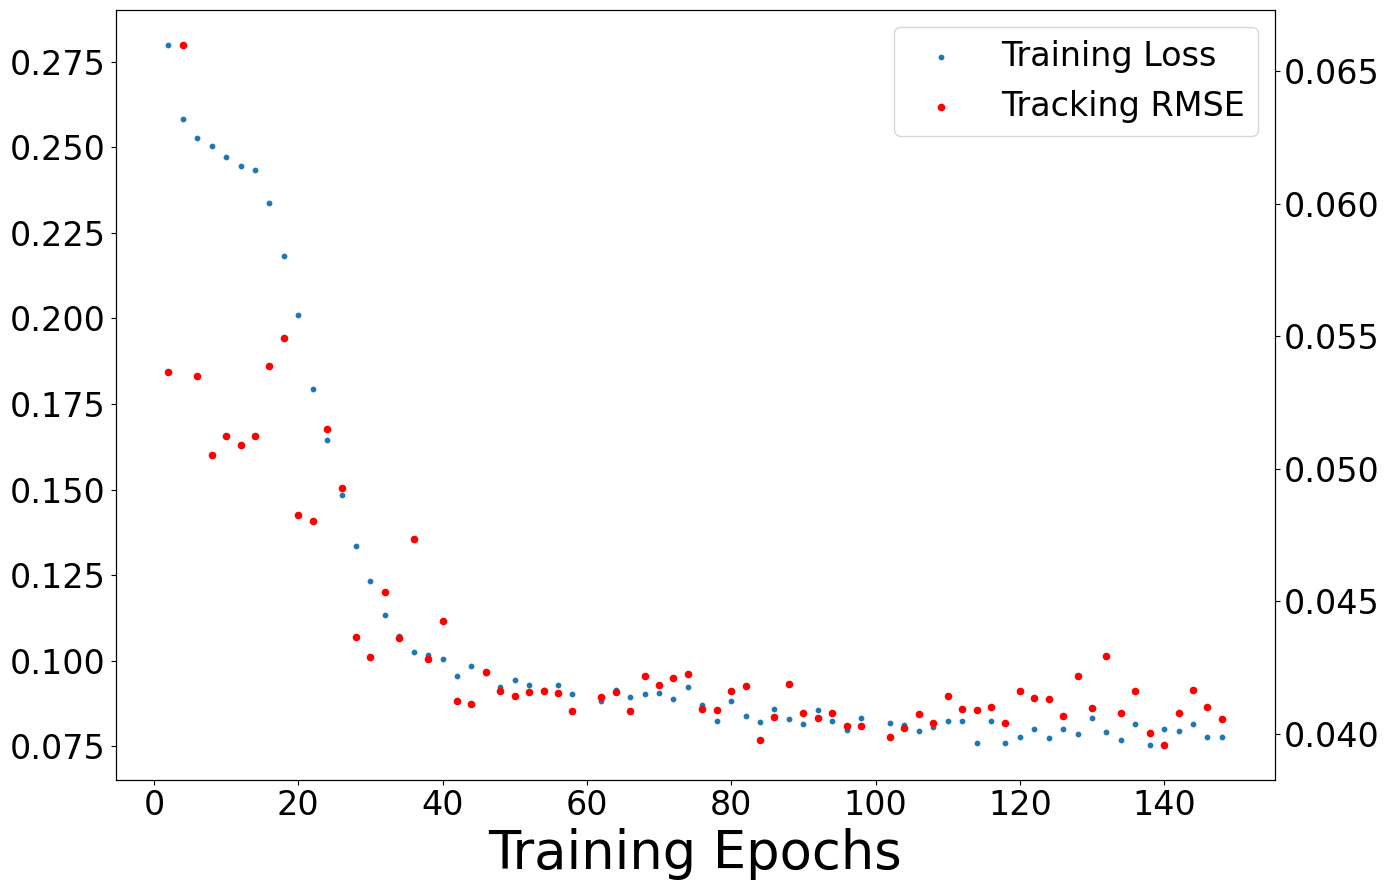

In [34]:
toSave = False
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=20, color="red",label="Tracking RMSE")
ax.set_xlabel("Training Epochs", fontsize=38)
if "BiPot" in config.data_path:
    ax.set_title(rf"Losses for StableTarget 4D Lorenz with $F={config.forcing_const}$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    pass
plt.show()
plt.close()

In [35]:
raise RuntimeError

RuntimeError: 

In [ ]:
curr_rmse = np.inf
toSave = False
for Nepoch in np.arange(config.max_epochs[-1]):
    try:
        num_diff_times = 1
    if "_ST_" in config.scoreNet_trained_path:
        save_path = (
                    project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_ST_{config.ndims}DLorenz_OOSDriftTrack_{Nepoch}Nep_tl{config.tdata_mult}data_{config.t0}t0_{config.deltaT:.3e}dT_{num_diff_times}NDT_{config.loss_factor}LFac_BetaMax{config.beta_max:.1e}_{round(config.forcing_const,3)}FConst").replace(
                ".", "")
        else:
            save_path = (
                project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_{config.ndims}DLorenz_OOSDriftTrack_{Nepoch}Nep_tl{config.tdata_mult}data_{config.t0}t0_{config.deltaT:.3e}dT_{num_diff_times}NDT_{config.loss_factor}LFac_BetaMax{config.beta_max:.1e}_{round(config.forcing_const,3)}FConst").replace(
            ".", "")
        all_true_states = np.load(save_path + "_true_states.npy")/np.sqrt(config.deltaT)
        all_local_states= np.load(save_path + "_local_states.npy")/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        total_local_errors_minq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], curr_rmse)
        if total_local_errors[-1] < curr_rmse:
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(time_steps, total_local_errors)
            #plt.fill_between(time_steps, total_local_errors_minq, total_local_errors_maxq, color="blue", alpha=0.2, label="95% Confidence Band")
            plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)

            ax.set_title(f"Cumulative RMSE for LSTM Score Estimator",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                if "_ST_" in config.data_path:
                    plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/f4DLnz_ST_OOSDriftTrack_{Nepoch}Nep_PM_LSTM_{config.forcing_const}FConst").replace(".", "")+".png")
                else:
                    plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/f4DLnz_OOSDriftTrack_{Nepoch}Nep_PM_LSTM_{config.forcing_const}FConst").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} with final IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at Nepoch {Nepoch} for {config.forcing_const}FConst\n")
    except FileNotFoundError as e:
        continue